In [1]:
import os
from tensorflow import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

from pathlib import Path
import numpy as np
import tensorflow as tf

2023-03-22 20:28:24.631680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 20:28:24.910103: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 20:28:24.910126: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-22 20:28:26.550156: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
train_dir = os.path.join('Training_Datasets', 'train')
validation_dir = os.path.join('Training_Datasets', 'val')

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 8, class_mode = 'categorical', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory( validation_dir, batch_size = 8, class_mode = 'categorical', target_size = (224, 224))


Found 4068 images belonging to 4 classes.
Found 1020 images belonging to 4 classes.


In [3]:
import efficientnet.keras as efn

base_model = keras.Sequential() 
base_model.add(efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet', classes=4))
base_model.add(GlobalAveragePooling2D())
base_model.add(Dropout(0.3))
base_model.add(Dense(4, activation="softmax"))

base_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

2023-03-22 20:28:30.864871: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 20:28:30.864897: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 20:28:30.864911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login4): /proc/driver/nvidia/version does not exist
2023-03-22 20:28:30.865084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
num_epochs = 10
eff_history = base_model.fit(train_generator, validation_data = validation_generator, epochs = num_epochs)

Epoch 1/10
509/509 [==============================] - 200s 374ms/step - loss: 0.8507 - accuracy: 0.6487 - val_loss: 0.5511 - val_accuracy: 0.7843
Epoch 2/10
509/509 [==============================] - 187s 368ms/step - loss: 0.5264 - accuracy: 0.7935 - val_loss: 0.3799 - val_accuracy: 0.8451
Epoch 3/10
509/509 [==============================] - 189s 371ms/step - loss: 0.4337 - accuracy: 0.8363 - val_loss: 0.3371 - val_accuracy: 0.8686
Epoch 4/10
509/509 [==============================] - 186s 365ms/step - loss: 0.3734 - accuracy: 0.8609 - val_loss: 0.3604 - val_accuracy: 0.8559
Epoch 5/10
509/509 [==============================] - 187s 368ms/step - loss: 0.3326 - accuracy: 0.8724 - val_loss: 0.3194 - val_accuracy: 0.8814
Epoch 6/10
509/509 [==============================] - 183s 359ms/step - loss: 0.2902 - accuracy: 0.8889 - val_loss: 0.3261 - val_accuracy: 0.8912
Epoch 7/10
509/509 [==============================] - 186s 365ms/step - loss: 0.2677 - accuracy: 0.8992 - val_loss: 0.3036 -

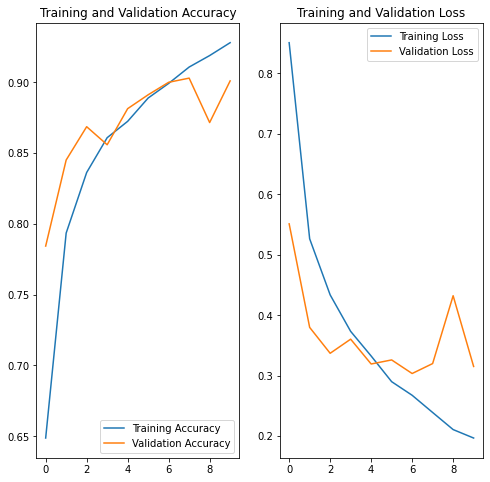

In [6]:
import matplotlib.pyplot as plt
acc = eff_history.history['accuracy'] 
val_acc = eff_history.history['val_accuracy']

loss = eff_history.history['loss'] 
val_loss = eff_history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8)) 
plt.subplot(1, 2, 1) 
plt.plot(epochs_range, acc, label='Training Accuracy') 
plt.plot(epochs_range, val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) 
plt.plot(epochs_range, loss, label='Training Loss') 
plt.plot(epochs_range, val_loss, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.title('Training and Validation Loss') 
plt.show()

In [10]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [40]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['efficientnet-b0_input'],
  'outputs': ['dense']}}

In [54]:

# Create a modified input tensor name with '-' replaced by '_'
base_model.input.name.replace('-', '_')


'efficientnet_b0_input'

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(base_model)
tflite_model = converter.convert()

with open('mo.tflite', 'wb') as f:
  f.write(tflite_model)

In [33]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [53]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['efficientnet-b0_input'],
  'outputs': ['dense']}}

In [19]:
class_names_train = list(train_generator.class_indices.keys())

print(class_names_train)

['Atlantic_Poison_Oak', 'Eastern_Poison_Ivy', 'Not', 'Poison_Sumac']


In [52]:
sunflower_path = 'sunflower.jpeg'

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(224, 224)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions_lite = classify_lite(efficientnet_b0_input=img_array)['dense']
score_lite = tf.nn.softmax(predictions_lite)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names_train[np.argmax(score)], 100 * np.max(score_lite))
)


ValueError: Invalid Input name (efficientnet_b0_input) for SignatureDef

In [36]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 4,054,688
Trainable params: 4,012,672
Non-trainable params: 42,016
_________________________________________________________________
